In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import src.config
import src.data
import src.model_new
import src.utils
from src.model_new import (
    T5EncoderModelForTokenClassification,
)

import gc
import copy
import random

import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import src.utils

from transformers import (
    T5Tokenizer,
    DataCollatorForTokenClassification,
    TrainingArguments,
    Trainer,
    TrainerCallback
)

import peft
from peft import (
    LoraConfig,
)

In [3]:
ROOT = src.utils.get_project_root_path()
device = torch.device('cuda:0' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print("Base Model:\t", src.config.base_model_name)
print("MPS:\t\t", torch.backends.mps.is_available())
print("Path:\t\t", ROOT)
print(f"Using device:\t {device}")

Base Model:	 Rostlab/prot_t5_xl_uniref50
MPS:		 False
Path:		 /home/ec2-user/developer/prottrans-t5-signalpeptide-prediction
Using device:	 cuda:0


In [4]:
t5_tokenizer = T5Tokenizer.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    do_lower_case=False,
    use_fast=True,
    legacy=False
)

In [5]:
FASTA_FILENAME = '5_SignalP_5.0_Training_set.fasta'
# FASTA_FILENAME = '5_SignalP_5.0_Training_set_testing.fasta'
annotations_name = 'Label' # Choose Type or Label

df_data = src.data.process(src.data.parse_file(ROOT + '/data/raw/' + FASTA_FILENAME))

dataset_signalp_type_splits = {}

for sequence_type in src.config.type_encoding.keys():
    dataset_signalp = src.model_new.create_datasets(
        splits=src.config.splits,
        tokenizer=t5_tokenizer,
        data=df_data,
        annotations_name=annotations_name,
        dataset_size=src.config.dataset_size,
        # dataset_size=3,
        encoder=src.config.select_encoding_type[sequence_type],
        sequence_type=sequence_type
        )
    dataset_signalp_type_splits.update({sequence_type: dataset_signalp})

del df_data

In [6]:
# dataset_signalp_type_splits
# dataset_signalp_type_splits['TAT']['train'][200]['labels']

expert = 'SP'
dataset_signalp = dataset_signalp_type_splits[expert]
# len(src.config.select_decoding_type[expert])
dataset_signalp

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2017
    })
    valid: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 679
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 676
    })
})

In [7]:
t5_base_model = T5EncoderModelForTokenClassification.from_pretrained(
    pretrained_model_name_or_path=src.config.base_model_name,
    device_map='auto',
    load_in_8bit=False,
    custom_num_labels=len(src.config.select_decoding_type[expert]),
    custom_dropout_rate=0.1,
)

tmp_lin = nn.Linear(
    in_features=t5_base_model.config.hidden_size,
    out_features=t5_base_model.custom_num_labels
)
t5_base_model.custom_classifier.weight = tmp_lin.weight
t5_base_model.custom_classifier.bias = tmp_lin.bias

lora_config = LoraConfig(
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=['q', 'k', 'v', 'o'],
    bias="none",
    modules_to_save=['custom_classifier'],
)

t5_lora_model = peft.get_peft_model(t5_base_model, lora_config)

Some weights of T5EncoderModelForTokenClassification were not initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50 and are newly initialized: ['custom_classifier.weight', 'custom_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
[x for x in t5_lora_model.custom_classifier.modules_to_save.default.named_parameters()]

[('weight',
  Parameter containing:
  tensor([[ 0.0239,  0.0259, -0.0073,  ..., -0.0119, -0.0269, -0.0198],
          [ 0.0174, -0.0047,  0.0133,  ...,  0.0008,  0.0057,  0.0295],
          [ 0.0145,  0.0067, -0.0063,  ...,  0.0145, -0.0186,  0.0159],
          [-0.0079,  0.0028, -0.0084,  ...,  0.0109, -0.0184,  0.0002]],
         requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0221,  0.0252,  0.0264,  0.0246], requires_grad=True))]

In [10]:
t5_lora_model.custom_classifier.modules_to_save.default.weight.mean()

tensor(-0.0002, grad_fn=<MeanBackward0>)

In [9]:
t5_lora_model.custom_classifier.modules_to_save.default.bias.mean()

tensor(0.0135, grad_fn=<MeanBackward0>)

In [11]:
data_collator = DataCollatorForTokenClassification(tokenizer=t5_tokenizer)

training_args = TrainingArguments(
    output_dir='./checkpoints',
    learning_rate=src.config.lr,
    per_device_train_batch_size=src.config.batch_size,
    per_device_eval_batch_size=src.config.batch_size,
    num_train_epochs=src.config.num_epochs,
    logging_steps=src.config.logging_steps,
    # save_strategy="steps",
    # save_steps=src.config.save_steps,
    # evaluation_strategy="steps",
    # eval_steps=src.config.eval_steps,
    # gradient_accumulation_steps=accum,
    # load_best_model_at_end=True,
    # save_total_limit=5,
    seed=42,
    # fp16=True,
    # deepspeed=deepspeed_config,
    remove_unused_columns=False,
    label_names=['labels'],
    # debug="underflow_overflow",
)

trainer = Trainer(
    model=t5_lora_model,
    args=training_args,
    train_dataset=dataset_signalp['train'],
    eval_dataset=dataset_signalp['valid'],
    data_collator=data_collator,
    compute_metrics=src.model_new.compute_metrics,
)

In [12]:
gc.collect()
torch.cuda.empty_cache()
# torch.mps.empty_cache()

In [13]:
trainer.train()

tensor(-0.4709, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4675, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')


Step,Training Loss
1,1.383700
2,1.385500
3,1.378200
4,1.369900
5,1.377100
6,1.366800
7,1.354100
8,1.352200
9,1.345500
10,1.345200


tensor(-0.4600, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5402, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')
tensor(-0.4716, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4788, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')
tensor(-0.4392, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8139, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')
tensor(-0.4940, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6035, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')
tensor(-0.4519, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4354, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')
tensor(-0.4271, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5726, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='cuda:0')
tensor(-0.5432, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5368, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(False, device='c

TrainOutput(global_step=127, training_loss=0.7657558720881544, metrics={'train_runtime': 184.6188, 'train_samples_per_second': 10.925, 'train_steps_per_second': 0.688, 'total_flos': 1041358417513296.0, 'train_loss': 0.7657558720881544, 'epoch': 1.0})

In [14]:
[x for x in t5_lora_model.custom_classifier.modules_to_save.default.named_parameters()]

[('weight',
  Parameter containing:
  tensor([[ 0.0187,  0.0257, -0.0138,  ..., -0.0137, -0.0291, -0.0223],
          [ 0.0132, -0.0048,  0.0069,  ..., -0.0011,  0.0031,  0.0270],
          [ 0.0205,  0.0038,  0.0005,  ...,  0.0159, -0.0243,  0.0217],
          [-0.0132,  0.0063, -0.0045,  ...,  0.0129, -0.0137, -0.0055]],
         device='cuda:0', requires_grad=True)),
 ('bias',
  Parameter containing:
  tensor([-0.0274,  0.0199,  0.0318,  0.0287], device='cuda:0',
         requires_grad=True))]

In [15]:
metrics=trainer.evaluate()
print(metrics)

tensor(-1.4134, device='cuda:0') tensor(2.5316, device='cuda:0')
tensor(False, device='cuda:0')


tensor(-1.3909, device='cuda:0') tensor(2.5564, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.4554, device='cuda:0') tensor(2.5889, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.5278, device='cuda:0') tensor(2.5794, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.5032, device='cuda:0') tensor(2.5227, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.3825, device='cuda:0') tensor(2.5083, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.4368, device='cuda:0') tensor(2.5718, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.3962, device='cuda:0') tensor(2.6592, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.3820, device='cuda:0') tensor(2.5595, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.3873, device='cuda:0') tensor(2.4675, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.4296, device='cuda:0') tensor(2.3423, device='cuda:0')
tensor(False, device='cuda:0')
tensor(-1.4261, device='cuda:0') tensor(

In [16]:
training_log = pd.DataFrame(trainer.state.log_history)
display(training_log)

,loss,learning_rate,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss,eval_loss,eval_accuracy_metric,eval_precision_metric,eval_recall_metric,eval_f1_metric,eval_matthews_correlation,eval_confusion_matrix,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,1.3837,9.921260e-05,0.01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.3855,9.842520e-05,0.02,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.3782,9.763780e-05,0.02,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.3699,9.685039e-05,0.03,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.3771,9.606299e-05,0.04,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.2088,1.574803e-06,0.98,125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125,0.2245,7.874016e-07,0.99,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
126,0.2008,0.000000e+00,1.00,127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,NaN,NaN,1.00,127,184.6188,10.925,0.688,1.041358e+15,0.765756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
training_log['eval_confusion_matrix'].iloc[-1]

array([[    0,     0,     0,     0],
       [    0,     0,     0,     0],
       [  107,   207, 30668,   441],
       [    0,     0,   265, 15611]])

In [18]:
display(pd.Series([item for row in dataset_signalp['train']['labels'] for item in row]).value_counts())
display(pd.Series([item for row in dataset_signalp['valid']['labels'] for item in row]).value_counts())
display(pd.Series([item for row in dataset_signalp['test']['labels'] for item in row]).value_counts())

2    92502
3    47167
1      617
0      314
Name: count, dtype: int64

2    30933
3    16052
1      207
0      107
Name: count, dtype: int64

2    31236
3    15677
1      112
0      100
Name: count, dtype: int64

{0: 'I', 1: 'M', 2: 'O', 3: 'S'}


<Axes: title={'center': 'Confusion Matrix'}, xlabel='Actual', ylabel='Predicted'>

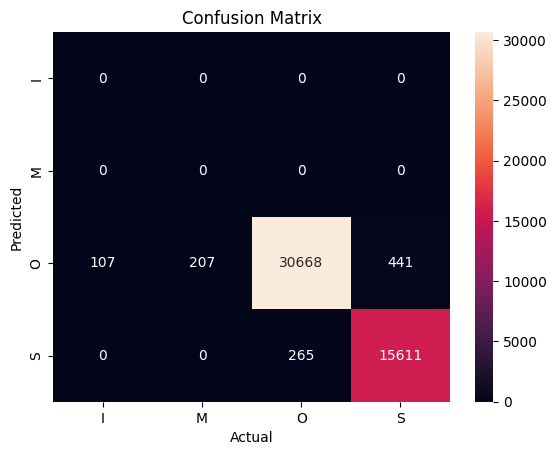

In [19]:
src.model_new.make_confusion_matrix(
    training_log['eval_confusion_matrix'].iloc[-1],
    src.config.select_decoding_type[expert])

In [ ]:
training_log = pd.DataFrame(trainer.state.log_history)
if 'eval_confusion_matrix' in training_log.columns:
    training_log['eval_confusion_matrix'] = training_log['eval_confusion_matrix'].apply(lambda x: x.tolist() if type(x)==np.ndarray else None)
adapter_location = '/models/expert_testing_1/' + expert + '_expert/'
t5_lora_model.save_pretrained(ROOT + adapter_location)
training_log.to_csv(ROOT + adapter_location + '/training_log.csv', index=False)
training_log.to_parquet(ROOT + adapter_location + '/training_log.parquet')

In [ ]:
_ds_index = 2
_ds_type = 'test'

_input_ids_test = t5_tokenizer.decode(dataset_signalp[_ds_type][_ds_index]['input_ids'])
_labels_test = torch.tensor(dataset_signalp[_ds_type][_ds_index]['labels'] + [-100]).to(device)
_attention_mask_test = torch.tensor([dataset_signalp[_ds_type][_ds_index]['attention_mask']]).to(device)

_labels_test_decoded = [src.config.label_decoding[x] for x in _labels_test.tolist()[:-1]]
print('Iput IDs:\t', _input_ids_test)
print('Labels:\t\t', *_labels_test.tolist())
print('Labels Decoded:\t', *_labels_test_decoded)
print('Attention Mask:\t', *_attention_mask_test.tolist()[0])
print('----')

preds = src.model_new.predict_model(
    sequence=_input_ids_test,
    tokenizer=t5_tokenizer,
    model=t5_lora_model,
    labels=_labels_test,
    attention_mask=_attention_mask_test,
    device=device,
    )

_result = src.model_new.translate_logits(preds.logits.cpu().numpy())
print('Result: \t',* _result)